# Movie Recommendation Systeme

This project aims to develop a movie recommendation system using a dataset of Netflix movies.  
Source : https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?select=titles.csv , Data collected from JustWatch.   
The data includes various features such as titles, genres, release years, and user ratings.   

The goal is to clean and preprocess the data, handle missing values, and build a recommendation engine that can suggest movies based on user preferences.   

1. Data Loading and Preparation : Loading the dataset, filtering for movies, and drop unnecessary columns.  
2. Data Transformation: Extracting genres and main production countries from the data.  
3. Handling Missing Values: Identifying and filling missing values using techniques such as imputation and prediction.  
4. Feature Engineering: Creating additional features like normalized scores and weighted ratings.  
5. Keyword Extraction: Extracting keywords from movie titles and descriptions using the YAKE algorithm.  
6. Visualization: Visualizing the distribution of movie ratings.  
7. Recommendation System: Implementing a recommendation system using content-based filtering and machine learning algorithms.  

Methods and Algorithms Used:
* Data Cleaning and Preprocessing  
* Feature Engineering
* Missing Value Imputation using Random Forest Regressor
* Keyword Extraction using YAKE (Yet Another Keyword Extractor)
* Data Visualization with Matplotlib and Seaborn
* Content-Based Filtering for Recommendations
* Nearest Neighbors Algorithm for Finding Similar Movies

In [3]:
#pip install git+https://github.com/LIAAD/yake

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
import yake

## Section 1 : Data Loading and Preparation

In [6]:
# Loading Data
df = pd.read_csv('input/titles.csv')

In [7]:
df.head(5)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [8]:
len(df)

5850

In [9]:
# Filtering Movies and Dropping Unnecessary Columns
df = df[df['type']=='MOVIE'].drop(['type','seasons','age_certification','imdb_id'], axis=1).reset_index(drop=True)

In [10]:
df.head(3)

,id,title,description,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,tm84618,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
1,tm154986,Deliverance,Intent on seeing the Cahulawassee River before...,1972,109,"['drama', 'action', 'thriller', 'european']",['US'],7.7,107673.0,10.010,7.300
2,tm127384,Monty Python and the Holy Grail,"King Arthur, accompanied by his squire, recrui...",1975,91,"['fantasy', 'action', 'comedy']",['GB'],8.2,534486.0,15.461,7.811


In [11]:
len(df)

3744

## Section 2 : Data Transformation

In [13]:
# Extracting genres
def extract_genres(genre_str):
    genre_list = ast.literal_eval(genre_str)
    first_genre = genre_list[0] if len(genre_list) > 0 else np.nan
    second_genre = genre_list[1] if len(genre_list) > 1 else "no_second-genre"
    return first_genre, second_genre

In [14]:
df[['first_genre', 'second_genre']] = df['genres'].apply(lambda x: pd.Series(extract_genres(x)))

In [15]:
df = df.drop('genres', axis=1)

In [16]:
# Extracting main production country
def extract_country(country_str):
    country_list = ast.literal_eval(country_str)
    country = country_list[0] if len(country_list) > 0 else np.nan
    return country

In [17]:
df["country"] = df["production_countries"].apply(extract_country)

In [18]:
df = df.drop('production_countries', axis=1)

## Section 3 : Handling Missing values

### Checking for Missing Values

In [21]:
def percent_missing(df):
    per_nan = 100*df.isnull().sum() /len(df)
    per_nan = per_nan[per_nan >0].sort_values()    
    return per_nan

In [22]:
percent_missing(df)

title              0.026709
description        0.240385
first_genre        0.908120
tmdb_popularity    1.655983
country            4.300214
tmdb_score         5.208333
imdb_score         8.413462
imdb_votes         8.840812
dtype: float64

### Dropping rows with Missing Titles and Descriptions

In [24]:
df = df.dropna(subset=['title', 'description'])

In [25]:
missing_value_line = df[df.isnull().sum(axis=1) >3]

In [26]:
df = df.drop(missing_value_line.index)

In [27]:
percent_missing(df)

first_genre        0.350783
tmdb_popularity    1.241230
country            3.642742
tmdb_score         4.533189
imdb_score         7.609282
imdb_votes         7.987048
dtype: float64

### Filling Missing "tmdb_score" and "imdb_score"

<Axes: xlabel='tmdb_score', ylabel='imdb_score'>

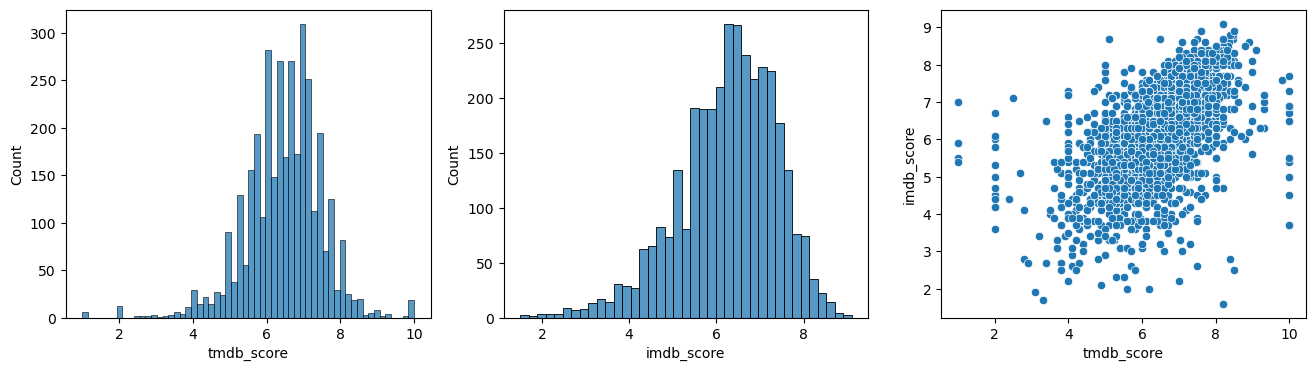

In [29]:
#plot distribution and corelation
fig,axes = plt.subplots(nrows=1,ncols=3, figsize=(16,4))
sns.histplot(df.tmdb_score, ax = axes[0])
sns.histplot(df.imdb_score, ax = axes[1])
sns.scatterplot(data=df, x ='tmdb_score',y='imdb_score')

In [30]:
# Filling missing values with each other
df['tmdb_score'] = df['tmdb_score'].fillna(df['imdb_score'])
df['imdb_score'] = df['imdb_score'].fillna(df['tmdb_score'])

In [31]:
# Drop down if the 2 are empty
drop_line = df[(df['imdb_score'].isnull())&(df['tmdb_score'].isnull())]
df = df.drop(drop_line.index)

In [32]:
percent_missing(df)

first_genre        0.353453
tmdb_popularity    1.250680
country            3.670473
imdb_votes         7.286569
dtype: float64

### Filling Missing Genres

In [34]:
missing_first_genre_indices = df[df['first_genre'].isnull()].index

In [35]:
genres_to_fill = ['drama', 'drama', 'animation', 'animation', 'animation', 'thriller', 'comedy', 'documentation', 'documentation', 'documentation', 'documentation', 'documentation']
for idx, genre in zip(missing_first_genre_indices, genres_to_fill):
    df.loc[idx, 'first_genre'] = genre

In [36]:
df = df.dropna(subset=['first_genre'])

In [37]:
percent_missing(df)

tmdb_popularity    1.251020
country            3.671471
imdb_votes         7.261354
dtype: float64

### Filling Missing Countries

In [39]:
df['country'].fillna('unknown_country', inplace=True)

In [40]:
percent_missing(df)

tmdb_popularity    1.251020
imdb_votes         7.261354
dtype: float64

### Filling "imdb_votes" and "tmdb_popularity" Missing Values

Random Forest Regressor to predict the popularity of these movies

In [43]:
len(df[df['imdb_votes'].isnull()])

267

In [44]:
# prediction with machine learning
def predict_missing_values(df, target_column):
    df_model = df[["release_year", "runtime", "first_genre", "country", "imdb_score", "tmdb_score", target_column]]
    df_model_obj = df_model[['first_genre', 'country']]
    df_model_dummies = pd.get_dummies(df_model_obj, drop_first=True)
    df_model_num = df_model.select_dtypes('number')
    df_model = pd.concat([df_model_num, df_model_dummies], axis=1)

    train_data = df_model.dropna(subset=[target_column])
    test_data = df_model[df_model[target_column].isnull()]
    X_train = train_data.drop(target_column, axis=1)
    y_train = train_data[target_column]

    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)

    X_test = test_data.drop(target_column, axis=1)
    predictions = model.predict(X_test)

    df.loc[df[target_column].isnull(), target_column] = predictions

In [45]:
predict_missing_values(df, 'tmdb_popularity')
df.tmdb_popularity.describe()

count    3677.000000
mean       20.416448
std        78.109718
min         0.055091
25%         2.570000
50%         5.960000
75%        14.718000
max      2274.044000
Name: tmdb_popularity, dtype: float64

In [46]:
predict_missing_values(df, 'imdb_votes')
df.imdb_votes.describe()

count    3.677000e+03
mean     2.713624e+04
std      1.096305e+05
min      5.000000e+00
25%      6.100000e+02
50%      2.594000e+03
75%      1.165500e+04
max      2.294231e+06
Name: imdb_votes, dtype: float64

## Section 4 : Keywords Extractions

ref article : https://www.analyticsvidhya.com/blog/2022/01/four-of-the-easiest-and-most-effective-methods-of-keyword-extraction-from-a-single-text-using-python/  
Yake: Campos, Ricardo, et al. “YAKE! Keyword extraction from single documents using multiple local features.” Information Sciences 509 (2020): 257-289.

In [49]:
def extract_keywords(title, text):
    combined_text = title + " " + text
    kw_extractor = yake.KeywordExtractor(top=3, stopwords=None, n=1)
    keywords = kw_extractor.extract_keywords(combined_text)
    # Extraire seulement les mots-clés, ignorer les scores
    return [kw for kw, v in keywords]

In [50]:
df['keywords'] = df.apply(lambda row: extract_keywords(row['title'], row['description']), axis=1)

In [51]:
# Formatting Keywords
def formatting_keywords(keywords):
    #keywords_list = ast.literal_eval(keywords_str)
    first_keyword = keywords[0] if len(keywords) > 0 else np.nan
    second_keyword = keywords[1] if len(keywords) > 1 else np.nan
    third_keyword = keywords[2] if len(keywords) > 2 else 'no_third_keywords'
    return first_keyword, second_keyword,third_keyword

In [52]:
df[['first_keyword', 'second_keyword', 'third_keyword']] = df['keywords'].apply(lambda x: pd.Series(formatting_keywords(x)))

In [53]:
df = df.drop('keywords', axis=1)
df = df.reset_index(drop=True)

In [54]:
df.head(5)

,id,title,description,release_year,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,first_genre,second_genre,country,first_keyword,second_keyword,third_keyword
0,tm84618,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,114,8.2,808582.0,40.965,8.179,drama,crime,US,Driver,Vietnam,War
1,tm154986,Deliverance,Intent on seeing the Cahulawassee River before...,1972,109,7.7,107673.0,10.010,7.300,drama,action,US,Intent,Cahulawassee,River
2,tm127384,Monty Python and the Holy Grail,"King Arthur, accompanied by his squire, recrui...",1975,91,8.2,534486.0,15.461,7.811,fantasy,action,GB,Sir,Arthur,Table
3,tm120801,The Dirty Dozen,12 American military prisoners in World War II...,1967,150,7.7,72662.0,20.398,7.600,war,action,GB,Dozen,American,Dirty
4,tm70993,Life of Brian,"Brian Cohen is an average young Jewish man, bu...",1979,94,8.0,395024.0,17.770,7.800,comedy,no_second-genre,GB,Messiah,Brian,Cohen


In [55]:
percent_missing(df)

Series([], dtype: float64)

## Section 5 : Calculating Weighted Scores

In [57]:
# Normalizing Scores
df['tmdb_popularity_norm'] = (df['tmdb_popularity'] - df['tmdb_popularity'].min()) / (df['tmdb_popularity'].max() - df['tmdb_popularity'].min())
df['imdb_votes_norm'] = (df['imdb_votes'] - df['imdb_votes'].min()) / (df['imdb_votes'].max() - df['imdb_votes'].min())

In [58]:
# Calculating Weighted Scores
df['weighted_imdb_score'] = df['imdb_score'] * df['imdb_votes_norm']
df['weighted_tmdb_score'] = df['tmdb_score'] * df['tmdb_popularity_norm']

In [59]:
df['my_rating'] = (df['weighted_imdb_score'] + df['weighted_tmdb_score']) / (df['imdb_votes_norm'] + df['tmdb_popularity_norm'])

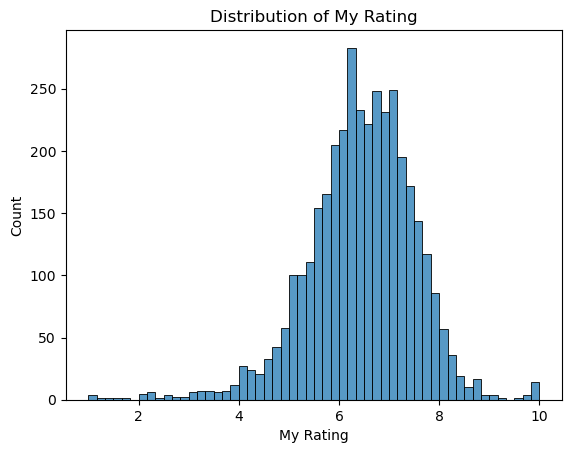

In [60]:
# Visualization : Distribution of 'My Rating'
sns.histplot(df['my_rating'])
plt.xlabel('My Rating')
plt.ylabel('Count')
plt.title('Distribution of My Rating')
plt.show()

In [61]:
df.head(3)

,id,title,description,release_year,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,first_genre,second_genre,country,first_keyword,second_keyword,third_keyword,tmdb_popularity_norm,imdb_votes_norm,weighted_imdb_score,weighted_tmdb_score,my_rating
0,tm84618,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,114,8.2,808582.0,40.965,8.179,drama,crime,US,Driver,Vietnam,War,0.017990,0.352440,2.890008,0.147143,8.198980
1,tm154986,Deliverance,Intent on seeing the Cahulawassee River before...,1972,109,7.7,107673.0,10.010,7.300,drama,action,US,Intent,Cahulawassee,River,0.004378,0.046930,0.361361,0.031957,7.665871
2,tm127384,Monty Python and the Holy Grail,"King Arthur, accompanied by his squire, recrui...",1975,91,8.2,534486.0,15.461,7.811,fantasy,action,GB,Sir,Arthur,Table,0.006775,0.232968,1.910337,0.052918,8.189007


## Section 6 : Saving Cleaned Data

In [63]:
df = df[['id', 'title', 'description', 'release_year', 'runtime', 'first_genre', 'second_genre', 'country', 'first_keyword', 'second_keyword', 'third_keyword', 'my_rating']] 

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3677 entries, 0 to 3676
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3677 non-null   object 
 1   title           3677 non-null   object 
 2   description     3677 non-null   object 
 3   release_year    3677 non-null   int64  
 4   runtime         3677 non-null   int64  
 5   first_genre     3677 non-null   object 
 6   second_genre    3677 non-null   object 
 7   country         3677 non-null   object 
 8   first_keyword   3677 non-null   object 
 9   second_keyword  3677 non-null   object 
 10  third_keyword   3677 non-null   object 
 11  my_rating       3677 non-null   float64
dtypes: float64(1), int64(2), object(9)
memory usage: 344.8+ KB


In [65]:
df.to_csv("input/movie_recom_pandas.csv", index=False)

In [66]:
#df = pd.read_csv("movie_recom_pandas.csv")

## Section 7 : Movie Recommendation System

### Filtering Based Recommendation

In [69]:
def recommend_movies(user_preferences, df):
    # fetch user input
    favorite_genre = user_preferences['favorite_genres']
    likes_old_movies = user_preferences['likes_old_movies']
    available_time = user_preferences['preferred_duration']
    favorite_country = user_preferences['preferred_country']
    
    # filter genre
    genre_filter = df['first_genre'].isin(favorite_genre) | df['second_genre'].isin(favorite_genre)
    recommended_movies = df[genre_filter]
    
    # filter date release
    if likes_old_movies == 'avant 2000': 
        recommended_movies = recommended_movies[recommended_movies['release_year'] < 2000]
    elif likes_old_movies == 'apres 2000': 
        recommended_movies = recommended_movies[recommended_movies['release_year'] >= 2000]
        
    # filter available time
    if available_time == '60-90' :
        recommended_movies = recommended_movies[recommended_movies['runtime'] <= 90]
    elif available_time == '90-120':
        recommended_movies = recommended_movies[(recommended_movies['runtime'] > 90) & (recommended_movies['runtime'] <= 120)]
    else:
        recommended_movies = recommended_movies[recommended_movies['runtime'] > 120]
        
    #filter country
    if favorite_country == 'US' :
        recommended_movies = recommended_movies[recommended_movies['country'] == 'US']
    elif favorite_country == 'GB' :
        recommended_movies = recommended_movies[recommended_movies['country'] == 'GB']
    elif favorite_country == 'FR' :
        recommended_movies = recommended_movies[recommended_movies['country'] == 'FR']
        
    # si aucun film trouvé : film similaire
    if recommended_movies.empty:
        print("pas de recommendation correspondant à vos filtre")
        
    return recommended_movies.sort_values('my_rating', ascending=False)

In [70]:
# Exemple de préférences utilisateur
user_preferences = {
    'favorite_genres': ['action'],
    'likes_old_movies': 'indifferent',
    'preferred_duration': '90-120',
    'preferred_country' : 'US'
}

In [71]:
recommended_movies = recommend_movies(user_preferences, df)

In [72]:
recommended_movies[['id','title']]

,id,title
186,tm997728,Blade Runner: The Final Cut
2020,tm441050,The Gentlemen
620,tm134967,How to Train Your Dragon 2
3371,tm963182,Trollhunters: Rise of the Titans
5,tm14873,Dirty Harry
...,...,...
2336,tm917822,The 2nd
2491,tm847623,Rogue Warfare: Death of a Nation
1561,tm427143,Edge of Fear
2128,tm411750,Doom: Annihilation


### Similarity-Based Recommendation

#### Preprocessing : Vectorization Keywords

In [75]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

In [76]:
# Combine keywords in a single cells
df['combined_keywords'] = df.apply(
    lambda row: f"{row['first_keyword']} {row['second_keyword']} {row['third_keyword']}", axis=1)

In [77]:
sentences = df['combined_keywords'].tolist()

In [78]:
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)

In [79]:
# Calculating mean vectors for each movies
def get_mean_vector(words):
    words = [word for word in words if word in word2vec_model.wv]
    if len(words) >= 1:
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

In [80]:
df['vector'] = df['combined_keywords'].apply(get_mean_vector)

#### Preprocessing : Dummies and features

In [82]:
# Encoding genres and country
df = pd.get_dummies(df, columns=['first_genre', 'second_genre', 'country'])

In [83]:
# Adding other features
features = df[['release_year', 'runtime'] 
                     + list(df.columns[df.columns.str.startswith('first_genre_')]) 
                     + list(df.columns[df.columns.str.startswith('second_genre_')]) 
                     + list(df.columns[df.columns.str.startswith('country_')])]

In [84]:
features

,release_year,runtime,first_genre_action,first_genre_animation,first_genre_comedy,first_genre_crime,first_genre_documentation,first_genre_drama,first_genre_family,first_genre_fantasy,...,country_TZ,country_UA,country_US,country_UY,country_VE,country_VN,country_XX,country_ZA,country_ZW,country_unknown_country
0,1976,114,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
1,1972,109,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
2,1975,91,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,1967,150,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1979,94,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3672,2021,25,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3673,2021,93,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3674,2021,100,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3675,2021,134,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


#### Preprocessing : Scaling and combined all features

In [86]:
# normalized / scale 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [87]:
# Adding the keywords vectors
vectors = np.array(df['vector'].tolist())
combined_features = np.hstack((vectors, features_scaled))

#### Implementing KNN

In [89]:
knn = NearestNeighbors(n_neighbors=10, metric='cosine').fit(combined_features)

## Section 8 : Testing Similarity-Based Recommendation

In [91]:
def recommend_movies(movie_id, n_recommendations=5):
    movie_index = df.index[df['id'] == movie_id][0]
    distances, indices = knn.kneighbors([combined_features[movie_index]])
    recommended_movies = df.iloc[indices[0][1:n_recommendations+1]]
    return recommended_movies[['id', 'title']]

In [92]:
movie_id = 'tm1097142'  # ID du film que l'utilisateur a aimé
recommendations = recommend_movies(movie_id)

In [93]:
recommendations

,id,title
1857,tm311193,Seeking a Man
1126,tm235232,Misunderstanding
2908,tm853091,The American Game
3001,tm815438,Sab el-Burumbah
2916,tm823848,Mohamed Hussein


In [107]:
def recommend_movies(liked_movie_ids, n_recommendations=5):
    movie_indices = [df.index[df['id'] == movie_id][0] for movie_id in liked_movie_ids]
    liked_movie_vectors = [combined_features[movie_index] for movie_index in movie_indices]
    average_vector = np.mean(liked_movie_vectors, axis=0)
    
    distances, indices = knn.kneighbors([average_vector])
    
    # Exclude already liked movies from the recommendations
    recommended_indices = []
    for index in indices[0]:
        movie_id = df.iloc[index]['id']
        if movie_id not in liked_movie_ids:
            recommended_indices.append(index)
        if len(recommended_indices) == n_recommendations:
            break
    
    recommended_movies = df.iloc[recommended_indices]
    
    
    return recommended_movies[['id', 'title']]


In [121]:
liked_movie_ids = ['tm84618', 'tm15897', 'tm25947', 'tm70807']  # IDs of the movies the user liked


In [123]:
recommendations = recommend_movies(liked_movie_ids)

In [125]:
recommendations

,id,title
117,tm192431,The Devil's Own
38,tm177480,Police Academy
26,tm336403,Khoon Khoon
6,tm119281,Bonnie and Clyde
34,tm180542,Once Upon a Time in America
